In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, label_binarize
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,auc, ConfusionMatrixDisplay, multilabel_confusion_matrix,roc_curve, roc_auc_score, mean_squared_error, r2_score
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
pd.set_option('display.max_rows', None)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

In [2]:
#using scaled and normalized data here and hoping it doesn't have a negative impact on the model
data = pd.read_csv('Data/cleaned_data.csv', index_col = 'Unnamed: 0')
data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,new_genre_hip hop,new_genre_indie,new_genre_jazz,new_genre_metal,new_genre_pop,new_genre_rap,new_genre_rock,new_genre_soul,new_genre_trance,energy_loudness
0,0.372240,-0.468348,0.116791,-0.559858,-0.666763,0.487650,-0.615265,1.052563,-0.135077,-0.568447,...,0,0,0,0,0,0,0,0,0,0.344461
1,1.060428,-0.629133,0.244546,-0.445405,-0.454801,0.699573,0.057137,0.756501,-0.588119,-0.930391,...,0,0,0,0,0,0,0,0,0,-0.025449
2,1.044875,-1.158739,0.507793,-0.895058,-0.623914,0.769216,-0.758285,0.237899,-1.637212,-0.582458,...,0,0,0,0,0,0,0,0,0,0.678709
3,1.118778,-0.723536,0.090359,-1.047643,-0.477436,0.437785,-0.831672,0.280016,-1.175705,-0.512976,...,0,0,0,0,0,0,0,0,0,0.871295
4,0.143436,-0.485108,0.138059,-0.140697,-0.669335,-0.092471,0.138538,0.058389,0.220791,-0.066867,...,0,0,0,0,0,0,0,0,0,-0.019492


In [3]:
data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'genre', 'mode', 'popularity_labels', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'new_genre_blues', 'new_genre_broadway',
       'new_genre_classical', 'new_genre_country', 'new_genre_edm',
       'new_genre_folk', 'new_genre_funk', 'new_genre_hip hop',
       'new_genre_indie', 'new_genre_jazz', 'new_genre_metal', 'new_genre_pop',
       'new_genre_rap', 'new_genre_rock', 'new_genre_soul', 'new_genre_trance',
       'energy_loudness'],
      dtype='object')

### Adding OneVsRest to the classifier and binarizing my classes

In [4]:
y = data['popularity_labels']
y = label_binarize(y, classes = [1,2,3])
n_classes = y.shape[1]
X = data.drop(columns = ['popularity_labels', 'genre'], axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify = y)

y_test = lb.fit_transform(y_test)

clf = OneVsRestClassifier(LogisticRegression(multi_class='ovr', solver='saga', penalty = 'l1', C = 1.6, max_iter = 700))
y_hat = clf.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_hat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_hat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


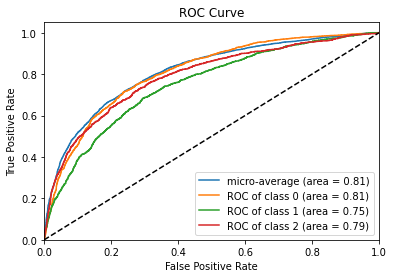

In [5]:
#visualize the ROC/ AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_hat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_hat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

A surprisingly great ROC curve! This is confusing considering all the other metrics have been so low. Let's dig a little deeper...

In [6]:
#look at the confusion matrix for each class after adding OneVsAll() to the classifier
cmv_multi = multilabel_confusion_matrix
cmv_multi(y_test.argmax(axis=1), y_hat.argmax(axis=1))

array([[[1716, 1454],
        [ 422, 2916]],

       [[4445,  445],
        [1018,  600]],

       [[4542,  414],
        [ 873,  679]]], dtype=int64)

In [7]:
ConfusionMatrixDisplay(confusion_matrix(y_test.argmax(axis = 1),
                                                   y_hat.argmax(axis = 1), labels = [0,1,2]));

In [8]:
#it looks like some classes perform better than others - so let's look at other metrics
from sklearn import metrics
print(metrics.classification_report(y_test.argmax(axis=1), y_hat.argmax(axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.667     0.874     0.757      3338
           1      0.574     0.371     0.451      1618
           2      0.621     0.438     0.513      1552

    accuracy                          0.645      6508
   macro avg      0.621     0.561     0.574      6508
weighted avg      0.633     0.645     0.623      6508



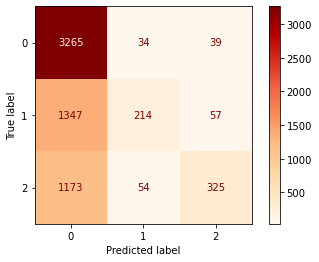

In [9]:
y_test_unb = lb.inverse_transform(y_test)
y_hat_unb = lb.inverse_transform(y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test_unb.argmax(axis = 1),
                                                   y_hat_unb.argmax(axis=1)))
disp.plot(cmap ='OrRd')

So we can see that recall is best for the 'Unsuccessful' class, but very poor in the other two, even after binarizing and using a OneVsRest approach. 

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_hat[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_hat[:, i])
    
# Find micro average
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_hat.ravel())
average_precision["micro"] = average_precision_score(y_test, y_hat,
                                                     average="micro")

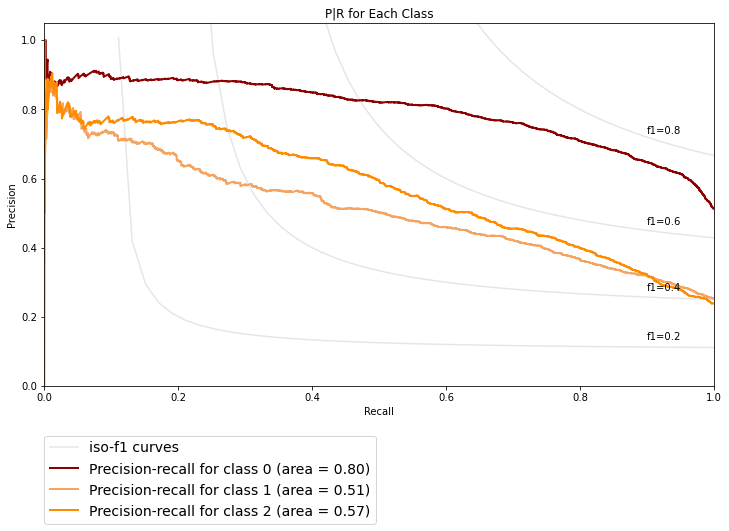

In [11]:
from itertools import cycle

colors = cycle(['darkred', 'sandybrown', 'darkorange', 'gold'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

#total score
#l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
#lines.append(l)
#labels.append('Precision-recall (area = {0:0.2f})'
 #             ''.format(average_precision["micro"]))

#independant class scores
for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R for Each Class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

plt.show()

In [12]:
print('ROC | AUC score: ',metrics.roc_auc_score(y_test, y_hat, multi_class = 'ovr').round(3))
print('Cohens Kappa score: ',metrics.cohen_kappa_score(y_test.argmax(axis=1), y_hat.argmax(axis=1)).round(3))

ROC | AUC score:  0.782
Cohens Kappa score:  0.383


After some research, I learned that ROC isn't the best metric for multiclass performance as it's typically biased towards the largest class (which we definietly see here). Because of this, it seemed best to try a metric that is better for multiclass models. 

Cohen's Kappa score resulted in a low score corresponding to a 'fair' agreement - leaning toward 'none to slight.' With a low CK score and metric scores showing only slightly better than chance, I cannot confidently reject the null hypothesis.   I had originally thought that this dataset wasn't imbalanced enough for SMOTE or other techniques, but it seems worth revisiting at this point. 

### Applying SMOTE 

In [13]:
y_notbinarized = data['popularity_labels']

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)

X_bal,y_bal = sm.fit_sample(X, y_notbinarized.ravel())

In [14]:
#check before and after value counts 
print('After SMOTE: \n {}'.format(np.array(np.unique(y_bal, return_counts=True)).T))
print('')
print('Before SMOTE: \n {}'.format(np.array(np.unique(y_notbinarized, return_counts=True)).T))

After SMOTE: 
 [[    1 16691]
 [    2 16691]
 [    3 16691]]

Before SMOTE: 
 [[    1 16691]
 [    2  8087]
 [    3  7761]]


Now that we have a balanced dataset, we can try modeling again to see if our model performace is more balanced as well

In [15]:
y = data['popularity_labels']
y = label_binarize(y, classes = [1,2,3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=.2, random_state=42)

y_test = lb.fit_transform(y_test)

clf = OneVsRestClassifier(LogisticRegression(multi_class='ovr', solver='saga', penalty = 'l1', C = 1.6, max_iter = 700))
y_hat = clf.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_hat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_hat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


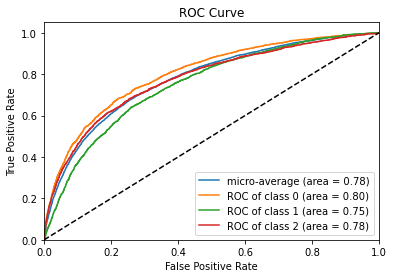

In [16]:
#visualize the ROC/ AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_hat[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_hat.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

SMOTE had a negative impact on the ROC AUC, with slightly lower AUCs for every class

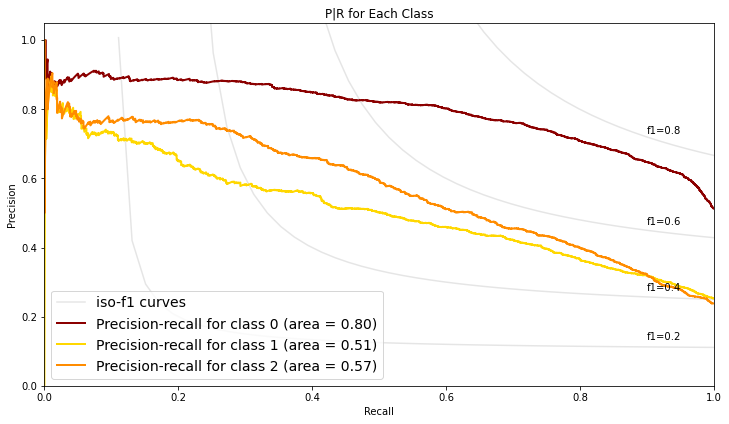

In [17]:
from itertools import cycle

colors = cycle(['darkred', 'gold', 'darkorange'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')

#looking at total score
#l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
#lines.append(l)
#labels.append('Precision-recall (area = {0:0.2f})'
 #             ''.format(average_precision["micro"]))

#independant class scores
for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R for Each Class')
plt.legend(lines, labels, prop=dict(size=14))

plt.show()

In [18]:
print(metrics.classification_report(y_test.argmax(axis=1), y_hat.argmax(axis=1), digits=3))

              precision    recall  f1-score   support

           0      0.613     0.654     0.633      3370
           1      0.592     0.559     0.575      3350
           2      0.626     0.619     0.622      3295

    accuracy                          0.611     10015
   macro avg      0.610     0.611     0.610     10015
weighted avg      0.610     0.611     0.610     10015



In [19]:
print('ROC | AUC score: ',metrics.roc_auc_score(y_test, y_hat, multi_class = 'ovr').round(3))
print('Cohens Kappa score: ',metrics.cohen_kappa_score(y_test.argmax(axis=1), y_hat.argmax(axis=1)).round(3))

ROC | AUC score:  0.775
Cohens Kappa score:  0.416


SMOTE had practically no impact on model performance when looking at ROC|AUC and PR curves, which isn't necessarily surprising as the data is only slightly imbalanced. It did, however balance out the independent precision/ recall scores -  unfortunately making them equally mediocre. (Ignoring the F1 score considering it's not a good measure for multiclass performance) 

Cohens Kappa is a bit higher, just barely landing in the 'moderate agreement' category as opposed to the 'fair agreement' category we saw pre-SMOTE

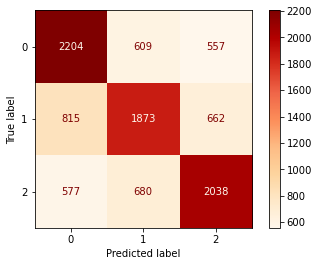

In [20]:
y_test_unb = lb.inverse_transform(y_test)
y_hat_unb = lb.inverse_transform(y_hat)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test_unb,
                                                   y_hat_unb))
disp.plot(cmap ='OrRd')

In [21]:
print('Recall Score: {}'.format(recall_score(y_test_unb, y_hat_unb, average = 'micro').round(3)))
print('Precision Score: {}'.format(precision_score(y_test_unb, y_hat_unb, average = 'micro').round(3)))
print('Accuracy Score: {}'.format(accuracy_score(y_test_unb, y_hat_unb).round(3)))

Recall Score: 0.611
Precision Score: 0.611
Accuracy Score: 0.611


### Conclusion
SMOTE absolutely helped in balancing out these results. Before SMOTE, many successful and very successful classes were being misclassed as unsuccessful - which is the opposite of what we want. Although the model is still not performing as well as I'd hoped, this is a great directional tool in determining success/ unsuccess of songs. 

For a full analysis and overview of these models, please visit the ReadMe.md 